# Regression Analysis

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [74]:
train_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2013/All_prefecture_Housing_training_data.csv")
dev_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2013/All_prefecture_Housing_dev_data.csv")
cols_to_exclude = ["Type","Prefecture","Municipality"]
train_data.drop(columns=cols_to_exclude, inplace=True)
dev_data.drop(columns=cols_to_exclude, inplace=True)

#cap = np.percentile(train_data["TradePrice"], 99.9)
# Remove rows where TradePrice is less than 1e5
train_data_filtered = train_data[train_data['TradePrice'] >= 1e5]
dev_data_filtered = dev_data[dev_data['TradePrice'] >= 1e5]
#train_data_filtered = train_data_filtered[train_data_filtered['TradePrice'] <= cap]
#dev_data_filtered = dev_data_filtered[dev_data_filtered['TradePrice'] <= cap]

In [98]:
print(train_data_filtered.describe())

         TradePrice           Area       Frontage  TotalFloorArea  \
count  3.181810e+05  318181.000000  318181.000000   318181.000000   
mean   3.403163e+07     203.354867      11.441149      140.081730   
std    7.201616e+07     193.224680       6.284084      170.452118   
min    1.000000e+05      25.000000       0.700000       10.000000   
25%    1.400000e+07     110.000000       7.500000       95.000000   
50%    2.600000e+07     160.000000      10.500000      105.000000   
75%    3.700000e+07     220.000000      14.000000      125.000000   
max    1.100000e+10    2000.000000      50.000000     2000.000000   

       BuildingYear           Year        Quarter  AvgTimeToNearestStation  \
count  318181.00000  318181.000000  318181.000000            318181.000000   
mean     2000.59860    2016.378420       2.499106                25.783501   
std        17.45887       1.585752       1.095547                24.021764   
min      1945.00000    2012.000000       1.000000                 

In [5]:
train_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318181 entries, 0 to 318251
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   TradePrice                         318181 non-null  int64  
 1   Area                               318181 non-null  int64  
 2   AreaIsGreaterFlag                  318181 non-null  bool   
 3   Frontage                           318181 non-null  float64
 4   FrontageIsGreaterFlag              318181 non-null  bool   
 5   TotalFloorArea                     318181 non-null  float64
 6   TotalFloorAreaIsGreaterFlag        318181 non-null  bool   
 7   BuildingYear                       318181 non-null  float64
 8   PrewarBuilding                     318181 non-null  bool   
 9   Year                               318181 non-null  int64  
 10  Quarter                            318181 non-null  int64  
 11  AvgTimeToNearestStation            318181 no

In [6]:

train_target = train_data_filtered['TradePrice'].values.astype(np.float32)
dev_target = dev_data_filtered['TradePrice'].values.astype(np.float32)


#train_target = np.minimum(train_target, cap)
#dev_target = np.minimum(dev_target, cap)
train_target_log = np.log(train_target + 1)
dev_target_log = np.log(dev_target + 1)

# Extract features (without the target) as before
train_features_filtered = train_data_filtered.drop('TradePrice', axis=1).values.astype(np.float32)
dev_features_filtered = dev_data_filtered.drop('TradePrice', axis=1).values.astype(np.float32)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(512),  # New: increased width
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1)
])

# Define the model - This model uses more sophsiticated tricks such as regularization but does not seem to help overall performance
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
#    normalizer,
#    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.00005), kernel_initializer='he_normal'),
#    tf.keras.layers.Dense(256),
# Optionally add a normalization layer here (e.g., BatchNormalization or LayerNormalization) - doesn't seem to help
#    tf.keras.layers.ReLU(),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.00005)),
#    tf.keras.layers.Dense(128),
# Optionally add a normalization layer here - doesn't seem to help a lot
#    tf.keras.layers.ReLU(),
#    tf.keras.layers.Dropout(0.1),
#    tf.keras.layers.Dense(1)
#])

# Learning rate schedule for exponential decay.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005, 
    decay_steps=100000, #Approximately every 10 epochs
    decay_rate=0.99, 
    staircase=True
)

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()






2025-04-07 21:02:02.142012: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/linuxbrew/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 24)             │            49 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,202 (692.20 KB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 49 (200.00 B)

In [7]:

# Plots true value vs predicted value (converted back from log space)
class PlotPredictionsCallback_log(tf.keras.callbacks.Callback):
    def __init__(self, dev_features, dev_target_log, out_dir="epoch_plots_log"):
        super().__init__()
        self.dev_features = dev_features
        self.dev_target_log = dev_target_log
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        preds_log = self.model.predict(self.dev_features).flatten()
        preds = np.exp(preds_log) - 1
        true_vals = np.exp(self.dev_target_log) - 1

        plt.figure(figsize=(6, 5))
        plt.scatter(true_vals, preds, alpha=0.3)
        plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'r--')
        plt.xlabel("True Price")
        plt.ylabel("Predicted Price")
        plt.title(f"True vs Predicted (Epoch {epoch+1})")
        plt.grid(True)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(f"{self.out_dir}/epoch_{epoch+1:03d}.png")
        plt.close()


In [8]:
#train_features_filtered = train_data_filtered.drop('TradePrice', axis=1).astype('float32').values
#dev_features_filtered = dev_data_filtered.drop('TradePrice', axis=1).astype('float32').values
plot_callback = PlotPredictionsCallback_log(dev_features_filtered, dev_target_log)
history = model.fit(
    train_features_filtered, train_target_log, 
    epochs=50, 
    batch_size=32, 
    validation_data=(dev_features_filtered, dev_target_log),
    callbacks=[plot_callback]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']




Epoch 1/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.7315 - val_loss: 0.4916
Epoch 2/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.4523 - val_loss: 0.4257
Epoch 3/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.4300 - val_loss: 0.3923
Epoch 4/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.4086 - val_loss: 0.4297
Epoch 5/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.4011 - val_loss: 0.4124
Epoch 6/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.3936 - val_loss: 0.3811
Epoch 7/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.3898 - val_loss: 0.3862
Epoch 8/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
9944/9944 

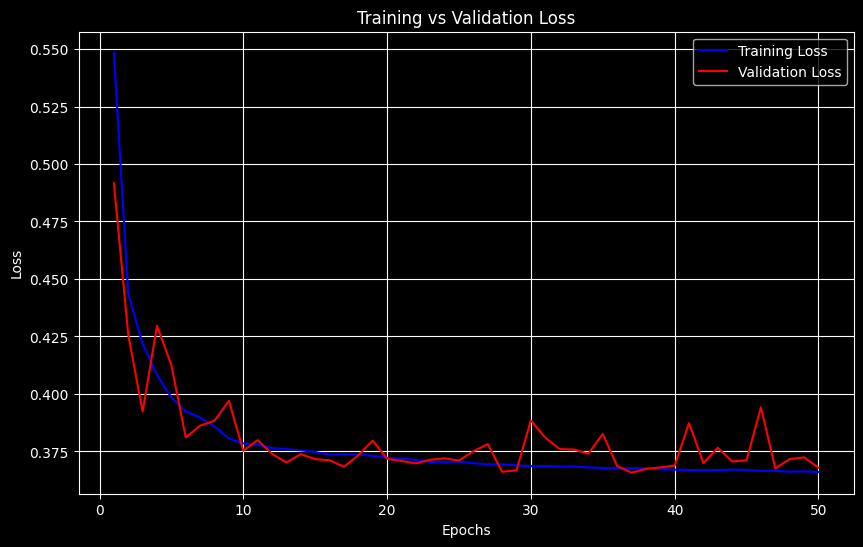

In [11]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(range(1, 51), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, 51), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step


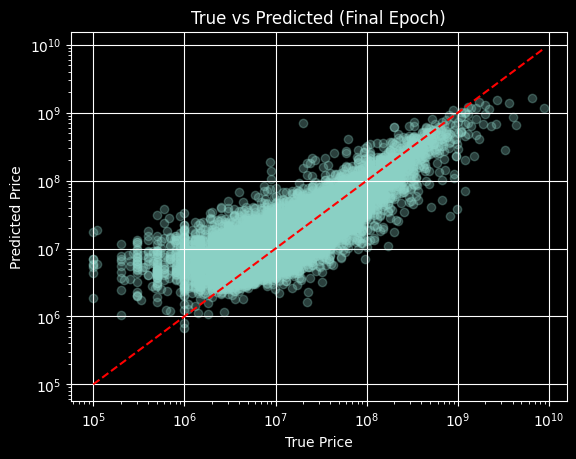

In [12]:
preds = model.predict(dev_features_filtered).flatten()
preds = np.exp(preds) - 1 
plt.style.use('dark_background')
plt.scatter(np.exp(dev_target_log) - 1, preds, alpha=0.3)
plt.plot([min(dev_target), max(dev_target)], [min(dev_target), max(dev_target)], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted (Final Epoch)")
plt.grid(True)
#plt.xlim(0,4e9)
#plt.ylim(0,4e9)
plt.xscale("log")
plt.yscale("log")
plt.show()

1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step


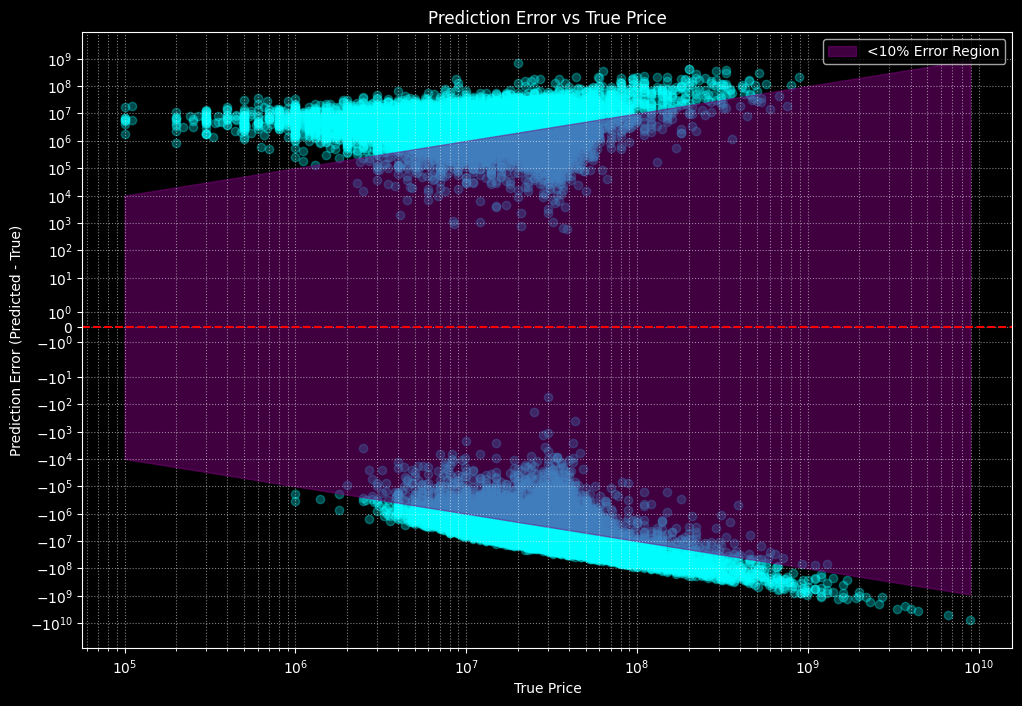

In [13]:

# Inverse transform predictions
preds = np.exp(model.predict(dev_features_filtered).flatten()) - 1

# Inverse transform the dev targets
true_prices = np.exp(dev_target_log) - 1

# Compute residuals (errors)
errors = preds - true_prices


fig, ax = plt.subplots(figsize=(12,8))

# Scatter plot of errors
ax.scatter(true_prices, errors, alpha=0.3, color='cyan')

# Reference line at zero error
ax.axhline(0, color='red', linestyle='--')

# Log scales
ax.set_xscale("log")
# Fill between -10% and +10% of the true price
x_region = np.linspace(true_prices.min(), true_prices.max(), 100)
ax.fill_between(x_region, -0.1 * x_region, 0.1 * x_region, color='purple', alpha=0.5, label='<10% Error Region')

# Labels and title
ax.set_xlabel("True Price")
ax.set_ylabel("Prediction Error (Predicted - True)")
ax.set_title("Prediction Error vs True Price")
ax.set_yscale("symlog")
# Grid and legend
ax.grid(True, which="both", linestyle=":", alpha=0.5)
ax.legend()

plt.show()



From the plot above it seems that the model consistently overestimates the price for lower true price values and is slightly prone to underestimating the price for very high true price values. Additionally and maybe not surprisingly, the most accurate estimates are those for which there is more data.

# New Approach

- Try to reduce compactify the data using 1:1 non-linear mappings
- Let's first center the data and apply the sigmoid function to see if this helps


In [14]:
from scipy.special import expit
from scipy.special import logit
# Centered trade prices
#train_target_centered = (train_data_filtered['TradePrice'].values.astype(np.float32) - train_data_filtered['TradePrice'].values.astype(np.float32).mean()) / train_data_filtered['TradePrice'].values.astype(np.float32).std()
#dev_target_centered = (dev_data_filtered['TradePrice'].values.astype(np.float32) - dev_data_filtered['TradePrice'].values.astype(np.float32).mean()) / dev_data_filtered['TradePrice'].values.astype(np.float32).std()
train_target_log_centered = (train_target_log - train_target_log.mean())/ train_target_log.std()
dev_target_log_centered = (dev_target_log - dev_target_log.mean())/ dev_target_log.std()
# Apply sigmoid and shift
train_sigmoid_shifted = expit(train_target_log_centered) + 10
dev_sigmoid_shifted = expit(dev_target_log_centered) + 10

In [82]:
print(train_target_log.mean())
print(train_target_log.std())
print(np.min(dev_sigmoid_shifted), np.max(dev_sigmoid_shifted))
print(logit(10.998094 - 10))
print(logit(10.003807 - 10))

16.885517
0.96101224
10.003807 10.998094
6.26084065502078
-5.5670995365126394


In [92]:

# Plots true value vs predicted value (converted back from log space)
class PlotPredictionsCallback_Sigmoid(tf.keras.callbacks.Callback):
    def __init__(self, dev_features, dev_sigmoid_shifted, out_dir="epoch_plots_sigmoid"):
        super().__init__()
        self.dev_features = dev_features
        self.dev_sigmoid_shifted = dev_sigmoid_shifted
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        preds_sigmoid = self.model.predict(self.dev_features).flatten()
        preds = preds_sigmoid - 10
        #print(train_target_log.mean())
        #print(np.min(preds), np.max(preds))
        #print(preds)
        preds = np.clip(preds, 1e-5, 1 - 1e-5)
        #print(np.min(preds), np.max(preds))
        preds = np.exp(((logit(preds)) * train_target_log.std()) + train_target_log.mean())
        #print(np.min(preds), np.max(preds))
        true_vals = dev_sigmoid_shifted - 10
        true_vals = np.clip(true_vals, 1e-5, 1 - 1e-5)
        true_vals = np.exp(((logit(true_vals)) * dev_target_log.std()) + dev_target_log.mean())
        #print(true_vals)
        #print(np.min(true_vals),np.max(true_vals))
        
        plt.figure(figsize=(6, 5))
        plt.scatter(true_vals, preds, alpha=0.3)
        plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'r--')
        plt.xlabel("True Price")
        plt.ylabel("Predicted Price")
        plt.title(f"True vs Predicted (Epoch {epoch+1})")
        plt.grid(True)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(f"{self.out_dir}/epoch_{epoch+1:03d}.png")
        plt.close()

In [93]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(512),  # New: increased width
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1)
])

# Learning rate schedule for exponential decay.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005, 
    decay_steps=100000, #Approximately every 10 epochs
    decay_rate=0.99, 
    staircase=True
)

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_21                │ (None, 24)             │            49 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 512)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_63 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_64 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_65 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,202 (692.20 KB)

 Trainable params: 177,153 (692.00 KB)

 Non-trainable params: 49 (200.00 B)

In [94]:
plot_callback_sigmoid = PlotPredictionsCallback_Sigmoid(dev_features_filtered, dev_sigmoid_shifted)

history = model.fit(
    train_features_filtered, train_sigmoid_shifted, 
    epochs=50, 
    batch_size=32, 
    validation_data=(dev_features_filtered, dev_sigmoid_shifted),
    callbacks=[plot_callback_sigmoid]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.3189 - val_loss: 0.0876
Epoch 2/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0921 - val_loss: 0.0951
Epoch 3/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0897 - val_loss: 0.0827
Epoch 4/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0879 - val_loss: 0.0886
Epoch 5/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0881 - val_loss: 0.1074
Epoch 6/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0875 - val_loss: 0.0859
Epoch 7/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step
9944/9944 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0868 - val_loss: 0.0890
Epoch 8/50
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
9944/9944 ━━━━

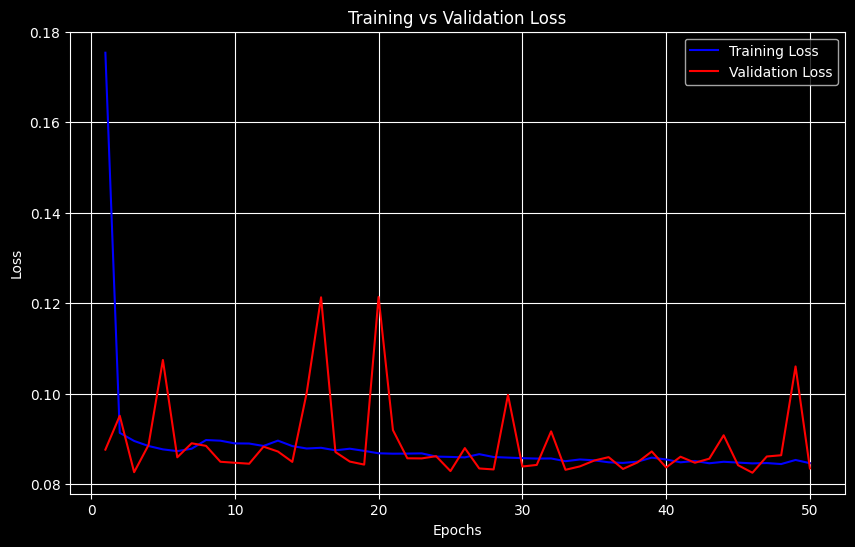

In [95]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(range(1, 51), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, 51), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,100)
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step


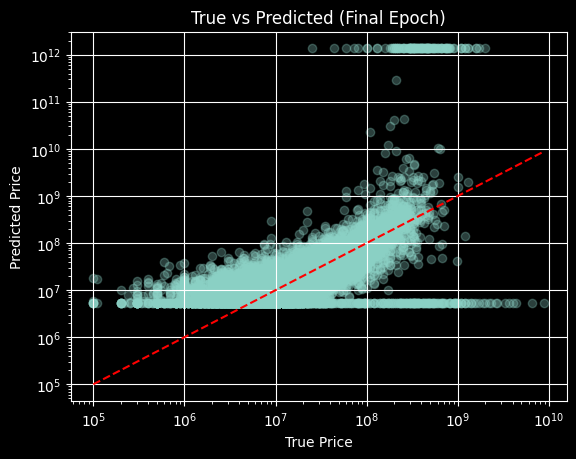

In [97]:
preds = model.predict(dev_features_filtered).flatten()
preds -= 10
preds = np.clip(preds, 1e-5, 1 - 1e-5)       
preds = np.exp(((logit(preds)) * train_target_log.std()) + train_target_log.mean())


true_vals = dev_sigmoid_shifted - 10
true_vals = np.clip(true_vals, 1e-5, 1 - 1e-5)
true_vals = np.exp(((logit(true_vals)) * dev_target_log.std()) + dev_target_log.mean())

plt.style.use('dark_background')
plt.scatter((true_vals), preds, alpha=0.3)
plt.plot([min(dev_target), max(dev_target)], [min(dev_target), max(dev_target)], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted (Final Epoch)")
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.show()

Uncertain what is happening here. After trying different architectures / regularization and data manipulation, the limiting factor may be the data set itself. Let's try and use a more up to date data set.